In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/ariel/mlops_zoomcamp/mlops_zoomcamp/mlruns/1', creation_time=1715361084938, experiment_id='1', last_update_time=1715361084938, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('intro/green_tripdata_2021-01.parquet')


In [4]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829626

/tmp/ipykernel_8339/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_8339/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


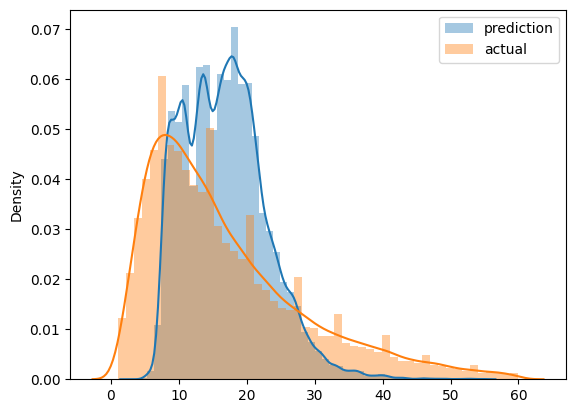

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('intro/green_tripdata_2021-01.parquet')
df_val = read_dataframe('intro/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)


(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715212021978

In [14]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
with mlflow.start_run():
    
    mlflow.set_tag("developer","ariel")
    mlflow.log_param("train-data-path",'intro/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path",'intro/green_tripdata_2021-02.parquet')

    
    alpha=0.1 
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse=mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse",rmse)

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [18]:

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.41840                          
[1]	validation-rmse:9.17223                           
[2]	validation-rmse:8.32140                           
[3]	validation-rmse:7.75081                           
[4]	validation-rmse:7.37828                           
[5]	validation-rmse:7.12793                           
[6]	validation-rmse:6.96843                           
[7]	validation-rmse:6.85301                           
[8]	validation-rmse:6.77906                           
[9]	validation-rmse:6.72271                           
[10]	validation-rmse:6.68776                          
[11]	validation-rmse:6.66123                          
[12]	validation-rmse:6.64257                          
[13]	validation-rmse:6.62855                          
[14]	validation-rmse:6.61663                          
[15]	validation-rmse:6.60892                          
[16]	validation-rmse:6.60185                          
[17]	validation-rmse:6.59609                          
[18]	valid

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.51888                                                   
[1]	validation-rmse:9.31449                                                    
[2]	validation-rmse:8.46937                                                    
[3]	validation-rmse:7.89508                                                    
[4]	validation-rmse:7.50290                                                    
[5]	validation-rmse:7.23547                                                    
[6]	validation-rmse:7.05675                                                    
[7]	validation-rmse:6.93348                                                    
[8]	validation-rmse:6.85095                                                    
[9]	validation-rmse:6.79114                                                    
[10]	validation-rmse:6.75038                                                   
[11]	validation-rmse:6.72360                                                   
[12]	validation-rmse:6.70051            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18829                                                   
[1]	validation-rmse:8.86342                                                    
[2]	validation-rmse:8.01672                                                    
[3]	validation-rmse:7.49664                                                    
[4]	validation-rmse:7.17310                                                    
[5]	validation-rmse:6.97789                                                    
[6]	validation-rmse:6.85423                                                    
[7]	validation-rmse:6.77354                                                    
[8]	validation-rmse:6.72267                                                    
[9]	validation-rmse:6.68804                                                    
[10]	validation-rmse:6.66478                                                   
[11]	validation-rmse:6.64515                                                   
[12]	validation-rmse:6.63346            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:10:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52264                                                    
[1]	validation-rmse:10.91022                                                    
[2]	validation-rmse:10.36721                                                    
[3]	validation-rmse:9.88944                                                     
[4]	validation-rmse:9.46634                                                     
[5]	validation-rmse:9.09669                                                     
[6]	validation-rmse:8.77373                                                     
[7]	validation-rmse:8.49119                                                     
[8]	validation-rmse:8.24735                                                     
[9]	validation-rmse:8.03091                                                     
[10]	validation-rmse:7.84547                                                    
[11]	validation-rmse:7.68340                                                    
[12]	validation-rmse:7.54478

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:12:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.30760                                                       
[1]	validation-rmse:7.12464                                                       
[2]	validation-rmse:6.77305                                                       
[3]	validation-rmse:6.66043                                                       
[4]	validation-rmse:6.61436                                                       
[5]	validation-rmse:6.59497                                                       
[6]	validation-rmse:6.58076                                                       
[7]	validation-rmse:6.57565                                                       
[8]	validation-rmse:6.56838                                                       
[9]	validation-rmse:6.56204                                                       
[10]	validation-rmse:6.55695                                                      
[11]	validation-rmse:6.55162                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.28871                                                     
[1]	validation-rmse:7.86345                                                     
[2]	validation-rmse:7.19605                                                     
[3]	validation-rmse:6.86570                                                     
[4]	validation-rmse:6.72030                                                     
[5]	validation-rmse:6.63953                                                     
[6]	validation-rmse:6.58736                                                     
[7]	validation-rmse:6.56310                                                     
[8]	validation-rmse:6.54738                                                     
[9]	validation-rmse:6.53379                                                     
[10]	validation-rmse:6.52171                                                    
[11]	validation-rmse:6.51590                                                    
[12]	validation-rmse:6.51189

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.81166                                                    
[1]	validation-rmse:11.43701                                                    
[2]	validation-rmse:11.08539                                                    
[3]	validation-rmse:10.75827                                                    
[4]	validation-rmse:10.45148                                                    
[5]	validation-rmse:10.16767                                                    
[6]	validation-rmse:9.90074                                                     
[7]	validation-rmse:9.65406                                                     
[8]	validation-rmse:9.42358                                                     
[9]	validation-rmse:9.21296                                                     
[10]	validation-rmse:9.01299                                                    
[11]	validation-rmse:8.83087                                                    
[12]	validation-rmse:8.65871

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:17:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03221                                                       
[1]	validation-rmse:10.07433                                                       
[2]	validation-rmse:9.30560                                                        
[3]	validation-rmse:8.69037                                                        
[4]	validation-rmse:8.20338                                                        
[5]	validation-rmse:7.82017                                                        
[6]	validation-rmse:7.52201                                                        
[7]	validation-rmse:7.28969                                                        
[8]	validation-rmse:7.11014                                                        
[9]	validation-rmse:6.96968                                                        
[10]	validation-rmse:6.86204                                                       
[11]	validation-rmse:6.77595                                                

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:18:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29093                                                      
[1]	validation-rmse:9.00811                                                       
[2]	validation-rmse:8.17859                                                       
[3]	validation-rmse:7.65347                                                       
[4]	validation-rmse:7.32283                                                       
[5]	validation-rmse:7.11657                                                       
[6]	validation-rmse:6.98358                                                       
[7]	validation-rmse:6.90039                                                       
[8]	validation-rmse:6.84534                                                       
[9]	validation-rmse:6.80931                                                       
[10]	validation-rmse:6.78186                                                      
[11]	validation-rmse:6.76301                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:19:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.08864                                                    
[1]	validation-rmse:7.68527                                                    
[2]	validation-rmse:7.09749                                                    
[3]	validation-rmse:6.85321                                                    
[4]	validation-rmse:6.74097                                                    
[5]	validation-rmse:6.68396                                                    
[6]	validation-rmse:6.65634                                                    
[7]	validation-rmse:6.63702                                                    
[8]	validation-rmse:6.62422                                                    
[9]	validation-rmse:6.61676                                                    
[10]	validation-rmse:6.61052                                                   
[11]	validation-rmse:6.60783                                                   
[12]	validation-rmse:6.60464            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25334                                                    
[1]	validation-rmse:10.44219                                                    
[2]	validation-rmse:9.75880                                                     
[3]	validation-rmse:9.18784                                                     
[4]	validation-rmse:8.71176                                                     
[5]	validation-rmse:8.31733                                                     
[6]	validation-rmse:7.99329                                                     
[7]	validation-rmse:7.72873                                                     
[8]	validation-rmse:7.51121                                                     
[9]	validation-rmse:7.33328                                                     
[10]	validation-rmse:7.18862                                                    
[11]	validation-rmse:7.06819                                                    
[12]	validation-rmse:6.97031

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:21:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60200                                                    
[1]	validation-rmse:11.04978                                                    
[2]	validation-rmse:10.55158                                                    
[3]	validation-rmse:10.10336                                                    
[4]	validation-rmse:9.69917                                                     
[5]	validation-rmse:9.33847                                                     
[6]	validation-rmse:9.01451                                                     
[7]	validation-rmse:8.72482                                                     
[8]	validation-rmse:8.46706                                                     
[9]	validation-rmse:8.23805                                                     
[10]	validation-rmse:8.03332                                                    
[11]	validation-rmse:7.85196                                                    
[12]	validation-rmse:7.69206

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48794                                                       
[1]	validation-rmse:10.84493                                                       
[2]	validation-rmse:10.27757                                                       
[3]	validation-rmse:9.77665                                                        
[4]	validation-rmse:9.33776                                                        
[5]	validation-rmse:8.95386                                                        
[6]	validation-rmse:8.61780                                                        
[7]	validation-rmse:8.32355                                                        
[8]	validation-rmse:8.07186                                                        
[9]	validation-rmse:7.85173                                                        
[10]	validation-rmse:7.66065                                                       
[11]	validation-rmse:7.49579                                                

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.90657                                                        
[1]	validation-rmse:7.52387                                                        
[2]	validation-rmse:6.97601                                                        
[3]	validation-rmse:6.75733                                                        
[4]	validation-rmse:6.64589                                                        
[5]	validation-rmse:6.60742                                                        
[6]	validation-rmse:6.57833                                                        
[7]	validation-rmse:6.55932                                                        
[8]	validation-rmse:6.54953                                                        
[9]	validation-rmse:6.53794                                                        
[10]	validation-rmse:6.53108                                                       
[11]	validation-rmse:6.52890                                                

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50679                                                       
[1]	validation-rmse:10.88059                                                       
[2]	validation-rmse:10.32743                                                       
[3]	validation-rmse:9.84009                                                        
[4]	validation-rmse:9.41190                                                        
[5]	validation-rmse:9.03711                                                        
[6]	validation-rmse:8.70973                                                        
[7]	validation-rmse:8.42427                                                        
[8]	validation-rmse:8.17594                                                        
[9]	validation-rmse:7.96116                                                        
[10]	validation-rmse:7.77505                                                       
[11]	validation-rmse:7.61433                                                

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.82867                                                        
[1]	validation-rmse:8.42766                                                        
[2]	validation-rmse:7.62588                                                        
[3]	validation-rmse:7.18551                                                        
[4]	validation-rmse:6.92596                                                        
[5]	validation-rmse:6.78369                                                        
[6]	validation-rmse:6.70008                                                        
[7]	validation-rmse:6.64385                                                        
[8]	validation-rmse:6.61079                                                        
[9]	validation-rmse:6.58904                                                        
[10]	validation-rmse:6.57334                                                       
[11]	validation-rmse:6.56167                                                

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72084                                                    
[1]	validation-rmse:11.26705                                                    
[2]	validation-rmse:10.84852                                                    
[3]	validation-rmse:10.46387                                                    
[4]	validation-rmse:10.10989                                                    
[5]	validation-rmse:9.78568                                                     
[6]	validation-rmse:9.48853                                                     
[7]	validation-rmse:9.21701                                                     
[8]	validation-rmse:8.96779                                                     
[9]	validation-rmse:8.74049                                                     
[10]	validation-rmse:8.53510                                                    
[11]	validation-rmse:8.34651                                                    
[12]	validation-rmse:8.17566

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31175                                                       
[1]	validation-rmse:6.62254                                                       
[2]	validation-rmse:6.52172                                                       
[3]	validation-rmse:6.49153                                                       
[4]	validation-rmse:6.47749                                                       
[5]	validation-rmse:6.47353                                                       
[6]	validation-rmse:6.46407                                                       
[7]	validation-rmse:6.45613                                                       
[8]	validation-rmse:6.44773                                                       
[9]	validation-rmse:6.43807                                                       
[10]	validation-rmse:6.43264                                                      
[11]	validation-rmse:6.42815                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07122                                                   
[1]	validation-rmse:10.14435                                                   
[2]	validation-rmse:9.39824                                                    
[3]	validation-rmse:8.80191                                                    
[4]	validation-rmse:8.33095                                                    
[5]	validation-rmse:7.96010                                                    
[6]	validation-rmse:7.67037                                                    
[7]	validation-rmse:7.44633                                                    
[8]	validation-rmse:7.27024                                                    
[9]	validation-rmse:7.13230                                                    
[10]	validation-rmse:7.02405                                                   
[11]	validation-rmse:6.93977                                                   
[12]	validation-rmse:6.87117            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68898                                                    
[1]	validation-rmse:7.32327                                                    
[2]	validation-rmse:6.82203                                                    
[3]	validation-rmse:6.63899                                                    
[4]	validation-rmse:6.55412                                                    
[5]	validation-rmse:6.51482                                                    
[6]	validation-rmse:6.49639                                                    
[7]	validation-rmse:6.48468                                                    
[8]	validation-rmse:6.47317                                                    
[9]	validation-rmse:6.46557                                                    
[10]	validation-rmse:6.46096                                                   
[11]	validation-rmse:6.45358                                                   
[12]	validation-rmse:6.45086            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02640                                                   
[1]	validation-rmse:10.06627                                                   
[2]	validation-rmse:9.29720                                                    
[3]	validation-rmse:8.68633                                                    
[4]	validation-rmse:8.20549                                                    
[5]	validation-rmse:7.82855                                                    
[6]	validation-rmse:7.53561                                                    
[7]	validation-rmse:7.30939                                                    
[8]	validation-rmse:7.13496                                                    
[9]	validation-rmse:7.00013                                                    
[10]	validation-rmse:6.89383                                                   
[11]	validation-rmse:6.81126                                                   
[12]	validation-rmse:6.74657            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79988                                                   
[1]	validation-rmse:11.41322                                                   
[2]	validation-rmse:11.05205                                                   
[3]	validation-rmse:10.71506                                                   
[4]	validation-rmse:10.40057                                                   
[5]	validation-rmse:10.10767                                                   
[6]	validation-rmse:9.83549                                                    
[7]	validation-rmse:9.58145                                                    
[8]	validation-rmse:9.34625                                                    
[9]	validation-rmse:9.12685                                                    
[10]	validation-rmse:8.92432                                                   
[11]	validation-rmse:8.73603                                                   
[12]	validation-rmse:8.56259            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:41:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72846                                                    
[1]	validation-rmse:11.28212                                                    
[2]	validation-rmse:10.87172                                                    
[3]	validation-rmse:10.49510                                                    
[4]	validation-rmse:10.14987                                                    
[5]	validation-rmse:9.83364                                                     
[6]	validation-rmse:9.54445                                                     
[7]	validation-rmse:9.28050                                                     
[8]	validation-rmse:9.03994                                                     
[9]	validation-rmse:8.82101                                                     
[10]	validation-rmse:8.62209                                                    
[11]	validation-rmse:8.44121                                                    
[12]	validation-rmse:8.27714

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:45:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86286                                                      
[1]	validation-rmse:9.80694                                                       
[2]	validation-rmse:8.99280                                                       
[3]	validation-rmse:8.37331                                                       
[4]	validation-rmse:7.90451                                                       
[5]	validation-rmse:7.55411                                                       
[6]	validation-rmse:7.29334                                                       
[7]	validation-rmse:7.10141                                                       
[8]	validation-rmse:6.95630                                                       
[9]	validation-rmse:6.84945                                                       
[10]	validation-rmse:6.76660                                                      
[11]	validation-rmse:6.70409                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:46:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.69955                                                     
[1]	validation-rmse:6.63596                                                     
[2]	validation-rmse:6.61685                                                     
[3]	validation-rmse:6.60302                                                     
[4]	validation-rmse:6.60056                                                     
[5]	validation-rmse:6.59336                                                     
[6]	validation-rmse:6.58881                                                     
[7]	validation-rmse:6.58375                                                     
[8]	validation-rmse:6.58227                                                     
[9]	validation-rmse:6.57236                                                     
[10]	validation-rmse:6.57105                                                    
[11]	validation-rmse:6.56628                                                    
[12]	validation-rmse:6.56121

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:47:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28807                                                   
[1]	validation-rmse:10.49786                                                   
[2]	validation-rmse:9.82661                                                    
[3]	validation-rmse:9.25957                                                    
[4]	validation-rmse:8.78244                                                    
[5]	validation-rmse:8.38418                                                    
[6]	validation-rmse:8.05098                                                    
[7]	validation-rmse:7.77559                                                    
[8]	validation-rmse:7.54661                                                    
[9]	validation-rmse:7.35856                                                    
[10]	validation-rmse:7.20161                                                   
[11]	validation-rmse:7.07433                                                   
[12]	validation-rmse:6.96865            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:49:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69872                                                    
[1]	validation-rmse:11.22644                                                    
[2]	validation-rmse:10.79359                                                    
[3]	validation-rmse:10.39739                                                    
[4]	validation-rmse:10.03535                                                    
[5]	validation-rmse:9.70474                                                     
[6]	validation-rmse:9.40354                                                     
[7]	validation-rmse:9.13004                                                     
[8]	validation-rmse:8.88159                                                     
[9]	validation-rmse:8.65639                                                     
[10]	validation-rmse:8.45171                                                    
[11]	validation-rmse:8.26695                                                    
[12]	validation-rmse:8.09967

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:51:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75447                                                    
[1]	validation-rmse:9.64208                                                     
[2]	validation-rmse:8.80484                                                     
[3]	validation-rmse:8.18346                                                     
[4]	validation-rmse:7.72852                                                     
[5]	validation-rmse:7.39476                                                     
[6]	validation-rmse:7.15381                                                     
[7]	validation-rmse:6.97695                                                     
[8]	validation-rmse:6.85052                                                     
[9]	validation-rmse:6.75369                                                     
[10]	validation-rmse:6.68455                                                    
[11]	validation-rmse:6.63206                                                    
[12]	validation-rmse:6.59266

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:52:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.66549                                                    
[1]	validation-rmse:9.50721                                                     
[2]	validation-rmse:8.65381                                                     
[3]	validation-rmse:8.03822                                                     
[4]	validation-rmse:7.59582                                                     
[5]	validation-rmse:7.28230                                                     
[6]	validation-rmse:7.05748                                                     
[7]	validation-rmse:6.89832                                                     
[8]	validation-rmse:6.78577                                                     
[9]	validation-rmse:6.70345                                                     
[10]	validation-rmse:6.64365                                                    
[11]	validation-rmse:6.59998                                                    
[12]	validation-rmse:6.56549

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:54:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.29015                                                   
[1]	validation-rmse:10.50209                                                   
[2]	validation-rmse:9.83362                                                    
[3]	validation-rmse:9.26872                                                    
[4]	validation-rmse:8.79387                                                    
[5]	validation-rmse:8.39789                                                    
[6]	validation-rmse:8.06740                                                    
[7]	validation-rmse:7.79347                                                    
[8]	validation-rmse:7.56667                                                    
[9]	validation-rmse:7.38078                                                    
[10]	validation-rmse:7.22583                                                   
[11]	validation-rmse:7.09961                                                   
[12]	validation-rmse:6.99399            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:55:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.78003                                                    
[1]	validation-rmse:6.87836                                                    
[2]	validation-rmse:6.69599                                                    
[3]	validation-rmse:6.63422                                                    
[4]	validation-rmse:6.61223                                                    
[5]	validation-rmse:6.60522                                                    
[6]	validation-rmse:6.59161                                                    
[7]	validation-rmse:6.58251                                                    
[8]	validation-rmse:6.57461                                                    
[9]	validation-rmse:6.56839                                                    
[10]	validation-rmse:6.56219                                                   
[11]	validation-rmse:6.55923                                                   
[12]	validation-rmse:6.55389            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:56:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.66447                                                    
[1]	validation-rmse:8.24798                                                    
[2]	validation-rmse:7.50149                                                    
[3]	validation-rmse:7.11222                                                    
[4]	validation-rmse:6.90811                                                    
[5]	validation-rmse:6.79748                                                    
[6]	validation-rmse:6.73455                                                    
[7]	validation-rmse:6.69851                                                    
[8]	validation-rmse:6.67243                                                    
[9]	validation-rmse:6.65844                                                    
[10]	validation-rmse:6.64938                                                   
[11]	validation-rmse:6.64269                                                   
[12]	validation-rmse:6.64013            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:56:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.64319                                                   
[1]	validation-rmse:9.47885                                                    
[2]	validation-rmse:8.62927                                                    
[3]	validation-rmse:8.01703                                                    
[4]	validation-rmse:7.58284                                                    
[5]	validation-rmse:7.27972                                                    
[6]	validation-rmse:7.06519                                                    
[7]	validation-rmse:6.91495                                                    
[8]	validation-rmse:6.80910                                                    
[9]	validation-rmse:6.73135                                                    
[10]	validation-rmse:6.67553                                                   
[11]	validation-rmse:6.63416                                                   
[12]	validation-rmse:6.60339            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:57:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71072                                                   
[1]	validation-rmse:11.24786                                                   
[2]	validation-rmse:10.82216                                                   
[3]	validation-rmse:10.43088                                                   
[4]	validation-rmse:10.07281                                                   
[5]	validation-rmse:9.74428                                                    
[6]	validation-rmse:9.44399                                                    
[7]	validation-rmse:9.16954                                                    
[8]	validation-rmse:8.92026                                                    
[9]	validation-rmse:8.69169                                                    
[10]	validation-rmse:8.48497                                                   
[11]	validation-rmse:8.29682                                                   
[12]	validation-rmse:8.12634            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:00:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99858                                                    
[1]	validation-rmse:8.61963                                                    
[2]	validation-rmse:7.80289                                                    
[3]	validation-rmse:7.31565                                                    
[4]	validation-rmse:7.03736                                                    
[5]	validation-rmse:6.86701                                                    
[6]	validation-rmse:6.76095                                                    
[7]	validation-rmse:6.69833                                                    
[8]	validation-rmse:6.65460                                                    
[9]	validation-rmse:6.62914                                                    
[10]	validation-rmse:6.60997                                                   
[11]	validation-rmse:6.59616                                                   
[12]	validation-rmse:6.58647            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:01:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.47830                                                   
[1]	validation-rmse:9.26010                                                    
[2]	validation-rmse:8.42439                                                    
[3]	validation-rmse:7.86261                                                    
[4]	validation-rmse:7.48894                                                    
[5]	validation-rmse:7.24239                                                    
[6]	validation-rmse:7.07928                                                    
[7]	validation-rmse:6.97157                                                    
[8]	validation-rmse:6.89610                                                    
[9]	validation-rmse:6.84404                                                    
[10]	validation-rmse:6.80628                                                   
[11]	validation-rmse:6.77885                                                   
[12]	validation-rmse:6.75681            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:02:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.74291                                                    
[1]	validation-rmse:6.72616                                                    
[2]	validation-rmse:6.71253                                                    
[3]	validation-rmse:6.70834                                                    
[4]	validation-rmse:6.70107                                                    
[5]	validation-rmse:6.69443                                                    
[6]	validation-rmse:6.68660                                                    
[7]	validation-rmse:6.67936                                                    
[8]	validation-rmse:6.67348                                                    
[9]	validation-rmse:6.66662                                                    
[10]	validation-rmse:6.66014                                                   
[11]	validation-rmse:6.65960                                                   
[12]	validation-rmse:6.66796            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:02:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.77170                                                    
[4]	validation-rmse:6.76126                                                    
[5]	validation-rmse:6.75317                                                    
[6]	validation-rmse:6.75011                                                    
[7]	validation-rmse:6.74840                                                    
[8]	validation-rmse:6.73843                                                    
[9]	validation-rmse:6.73604                                                    
[10]	validation-rmse:6.73047                                                   
[11]	validation-rmse:6.72957                                                   
[12]	validation-rmse:6.72637                                                   
[13]	validation-rmse:6.72128                                                   
[14]	validation-rmse:6.71784                                                   
[15]	validation-rmse:6.71258            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:03:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.41808                                                   
[1]	validation-rmse:10.72412                                                   
[2]	validation-rmse:10.12018                                                   
[3]	validation-rmse:9.59710                                                    
[4]	validation-rmse:9.14515                                                    
[5]	validation-rmse:8.75655                                                    
[6]	validation-rmse:8.42390                                                    
[7]	validation-rmse:8.14039                                                    
[8]	validation-rmse:7.89725                                                    
[9]	validation-rmse:7.69176                                                    
[10]	validation-rmse:7.51802                                                   
[11]	validation-rmse:7.36761                                                   
[12]	validation-rmse:7.24209            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:05:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79384                                                   
[1]	validation-rmse:11.40257                                                   
[2]	validation-rmse:11.03761                                                   
[3]	validation-rmse:10.69757                                                   
[4]	validation-rmse:10.38019                                                   
[5]	validation-rmse:10.08611                                                   
[6]	validation-rmse:9.81133                                                    
[7]	validation-rmse:9.55698                                                    
[8]	validation-rmse:9.32124                                                    
[9]	validation-rmse:9.10140                                                    
[10]	validation-rmse:8.89869                                                   
[11]	validation-rmse:8.71115                                                   
[12]	validation-rmse:8.53861            

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:07:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63012                                                     
[1]	validation-rmse:11.10252                                                     
[2]	validation-rmse:10.62614                                                     
[3]	validation-rmse:10.19689                                                     
[4]	validation-rmse:9.81054                                                      
[5]	validation-rmse:9.46384                                                      
[6]	validation-rmse:9.15362                                                      
[7]	validation-rmse:8.87657                                                      
[8]	validation-rmse:8.62926                                                      
[9]	validation-rmse:8.40922                                                      
[10]	validation-rmse:8.21367                                                     
[11]	validation-rmse:8.04004                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:08:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39864                                                     
[1]	validation-rmse:10.69315                                                     
[2]	validation-rmse:10.08423                                                     
[3]	validation-rmse:9.56118                                                      
[4]	validation-rmse:9.11228                                                      
[5]	validation-rmse:8.73117                                                      
[6]	validation-rmse:8.40731                                                      
[7]	validation-rmse:8.13407                                                      
[8]	validation-rmse:7.90178                                                      
[9]	validation-rmse:7.70718                                                      
[10]	validation-rmse:7.54328                                                     
[11]	validation-rmse:7.40487                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:09:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60810                                                     
[1]	validation-rmse:11.06098                                                     
[2]	validation-rmse:10.56825                                                     
[3]	validation-rmse:10.12438                                                     
[4]	validation-rmse:9.72615                                                      
[5]	validation-rmse:9.36912                                                      
[6]	validation-rmse:9.04924                                                      
[7]	validation-rmse:8.76444                                                      
[8]	validation-rmse:8.51093                                                      
[9]	validation-rmse:8.28618                                                      
[10]	validation-rmse:8.08651                                                     
[11]	validation-rmse:7.90980                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:11:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76695                                                     
[1]	validation-rmse:11.35217                                                     
[2]	validation-rmse:10.96691                                                     
[3]	validation-rmse:10.61027                                                     
[4]	validation-rmse:10.27946                                                     
[5]	validation-rmse:9.97320                                                      
[6]	validation-rmse:9.69044                                                      
[7]	validation-rmse:9.42938                                                      
[8]	validation-rmse:9.18828                                                      
[9]	validation-rmse:8.96565                                                      
[10]	validation-rmse:8.76136                                                     
[11]	validation-rmse:8.57406                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:13:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13462                                                     
[1]	validation-rmse:10.24147                                                     
[2]	validation-rmse:9.50751                                                      
[3]	validation-rmse:8.90804                                                      
[4]	validation-rmse:8.42212                                                      
[5]	validation-rmse:8.03068                                                      
[6]	validation-rmse:7.71735                                                      
[7]	validation-rmse:7.46700                                                      
[8]	validation-rmse:7.26829                                                      
[9]	validation-rmse:7.11016                                                      
[10]	validation-rmse:6.98610                                                     
[11]	validation-rmse:6.88619                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:15:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45153                                                      
[1]	validation-rmse:10.78551                                                      
[2]	validation-rmse:10.20441                                                      
[3]	validation-rmse:9.70165                                                       
[4]	validation-rmse:9.26666                                                       
[5]	validation-rmse:8.89158                                                       
[6]	validation-rmse:8.57017                                                       
[7]	validation-rmse:8.29560                                                       
[8]	validation-rmse:8.06010                                                       
[9]	validation-rmse:7.85968                                                       
[10]	validation-rmse:7.68972                                                      
[11]	validation-rmse:7.54445                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:16:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57178                                                     
[1]	validation-rmse:10.99991                                                     
[2]	validation-rmse:10.48542                                                     
[3]	validation-rmse:10.02863                                                     
[4]	validation-rmse:9.61874                                                      
[5]	validation-rmse:9.25607                                                      
[6]	validation-rmse:8.93931                                                      
[7]	validation-rmse:8.64999                                                      
[8]	validation-rmse:8.40429                                                      
[9]	validation-rmse:8.17983                                                      
[10]	validation-rmse:7.98668                                                     
[11]	validation-rmse:7.81876                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:18:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19517                                                      
[1]	validation-rmse:10.34608                                                      
[2]	validation-rmse:9.64271                                                       
[3]	validation-rmse:9.06286                                                       
[4]	validation-rmse:8.58955                                                       
[5]	validation-rmse:8.20393                                                       
[6]	validation-rmse:7.89072                                                       
[7]	validation-rmse:7.63930                                                       
[8]	validation-rmse:7.43595                                                       
[9]	validation-rmse:7.27348                                                       
[10]	validation-rmse:7.14201                                                      
[11]	validation-rmse:7.03781                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:20:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.66618                                                     
[1]	validation-rmse:11.16732                                                     
[2]	validation-rmse:10.71357                                                     
[3]	validation-rmse:10.30128                                                     
[4]	validation-rmse:9.92727                                                      
[5]	validation-rmse:9.58831                                                      
[6]	validation-rmse:9.28214                                                      
[7]	validation-rmse:9.00590                                                      
[8]	validation-rmse:8.75716                                                      
[9]	validation-rmse:8.53403                                                      
[10]	validation-rmse:8.33353                                                     
[11]	validation-rmse:8.15388                                                     
[12]	validation-

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:22:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43950                                                      
[1]	validation-rmse:10.76308                                                      
[2]	validation-rmse:10.17442                                                      
[3]	validation-rmse:9.66263                                                       
[4]	validation-rmse:9.22239                                                       
[5]	validation-rmse:8.84079                                                       
[6]	validation-rmse:8.51467                                                       
[7]	validation-rmse:8.23311                                                       
[8]	validation-rmse:7.99386                                                       
[9]	validation-rmse:7.79258                                                       
[10]	validation-rmse:7.61864                                                      
[11]	validation-rmse:7.46884                                                      
[12]

/home/ariel/.cache/pypoetry/virtualenvs/mlops-zoomcamp-vQfEKNh3-py3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

